# Maximum Likelihood Method



Lets start with a simple Gaussian distribution. 

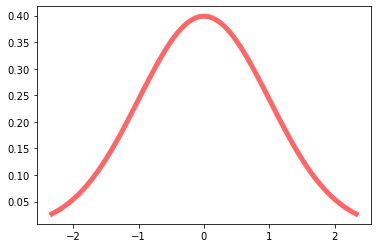

In [22]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

We can retrieve the probability of events happening, e.g. x=3.0

In [23]:
p_3 = norm.pdf(3.0, 5.0, 3.0)

We can also easily calculate the joint probability of iid (indepenent and identically distributed) events 

In [24]:
p_7 = norm.pdf(7.0, 7.0, 3.0)

joint = p_3*p_7

Assume now that someone is giving us an array of values and ask us to estimate a $p_{model}$ that is a 'good fit' to the gievn data. How we can go about solving this problem with Maximum Likelihood Estimation (MLE)? Notice that as addressed in [3], probability and likelihood have a reverse relationship.  Probability attaches to possible results; likelihood attaches to hypotheses. The likelihood function gives the relative likelihoods of different values for the parameter(s) of the distribution from which the data are assumed to have been drawn, given those data.

Lets plot a couple of $p_{model}$ hypotheses - the data are shown below in the same plot. Both hypotheses are plausible.  

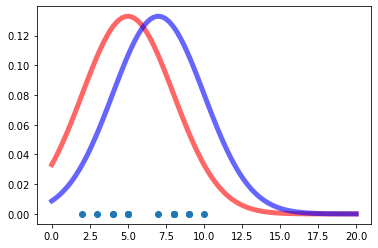

In [25]:
data = [4, 5, 7, 8, 8, 9, 10, 5, 2, 3, 5, 4, 8, 9]

fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 20, 100)
ax.plot(x, norm.pdf(x,5,3),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.plot(x, norm.pdf(x,7,3),
       'b-', lw=5, alpha=0.6, label='norm pdf')
ax.plot(data, np.zeros(len(data)).tolist(),'o')

As detailed in Ref [2], its important to safeguard against underflow that may well result from multiplying many numbers (for large datasets) that are less than 1.0 (probabilities). So we do the calculations in the log domain using the identity

$$log(a \times b)=log(a) + log(b)$$

Lets look at a function that calculates the log-likelihood for the two hypotheses above given the data denoted by $x$. 

In [26]:
def compare_data_to_dist(x, mu_1=5, mu_2=7, sd_1=3, sd_2=3):
    ll_1 = 0
    ll_2 = 0
    for i in x:
        ll_1 += np.log(norm.pdf(i, mu_1, sd_1))
        ll_2 += np.log(norm.pdf(i, mu_2, sd_2))
    
    print("The LL of of x for mu = %d and sd = %d is: %.4f" % (mu_1, sd_1, ll_1))
    print("The LL of of x for mu = %d and sd = %d is: %.4f" % (mu_2, sd_2, ll_2))


We can readily compate the two hypotheses according to the maximum likelihood criterion. Note that because the $log$ is a monotonic function, the conclusion as to which hypothesis makes the data more likely is the same in the natural or the $log$ domain. 

In [27]:
ll_comparison = compare_data_to_dist(data)

The LL of of x for mu = 5 and sd = 3 is: -33.9679
The LL of of x for mu = 7 and sd = 3 is: -33.3013


It seems that the second hypothesis 

$$p_{model}(x|\mathbf{w}) = N(x | [\mu_2, \sigma_2^2])$$

is preferred compared to the first. 

We can now start searching the hypothesis space (parameter space) for the best parameter set $\mathbf w$. 

The max LL for sd 0.50 is 167.88
The max LL for sd 1.50 is 36.84
The max LL for sd 2.50 is 32.28
The max LL for sd 3.50 is 33.77
The max LL for sd 4.50 is 35.96


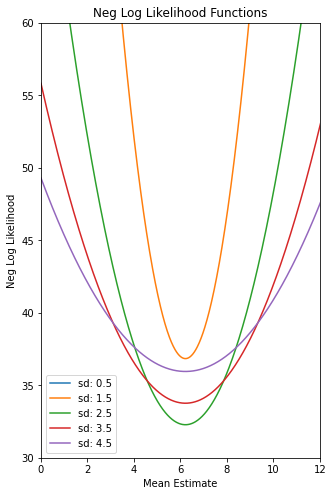

In [28]:
# Plot the Negative Log Likelihood Functions for different values of mu 
# and sigma
def plot_ll(x):
    plt.figure(figsize=(5,8))
    plt.title("Neg Log Likelihood Functions")
    plt.xlabel("Mean Estimate")
    plt.ylabel("Neg Log Likelihood")
    plt.ylim(30, 60)
    plt.xlim(0, 12)
    mu_set = np.linspace(0, 16, 1000)
    sd_set = [.5, 1.5, 2.5, 3.5, 4.5]
    max_val = max_val_location = None
    for i in sd_set:
        ll_array = []
        
        for j in mu_set:
            temp_mm = 0
            
            for k in x:
                temp_mm += np.log(norm.pdf(k, j, i)) # The LL function
            ll_array.append(-temp_mm) # negative LL
        
            if (max_val is None):
                max_val = min(ll_array)
            elif max(ll_array) > max_val:
                max_val = min(ll_array)
                max_val_location = j
        
        # Plot the results
        plt.plot(mu_set, ll_array, label="sd: %.1f" % i)
        
        print("The max LL for sd %.2f is %.2f" % (i, min(ll_array)))    
    plt.axvline(x=max_val_location, color='black', ls='-.')
    plt.legend(loc='lower left')
plot_ll(data);


But there is a better method than exhaustively searching in the parameter space. We developed a method that incrementally minimizes a loss function that is ultimately linked to the concept of entropy - the cross entropy (CE) that for the supervided learning problem as shown in the notes has a lot to do with minimizing the KL divergence - a type of probabilistic 'distance' between $\hat p_{data}$ and $p_{model}$. 

This method is the Stochastic Gradient Descent. Can ypu estimate the hypothesis for the `data` array above? 

In [41]:
def get_weights(x, y, verbose = 0):
    shape = x.shape
    x = np.insert(x, 0, 1, axis=1)
    w = np.ones((shape[1]+1,))
    weights = []

    learning_rate = 10
    iteration = 10
    loss = None
    while iteration <= 1000 and loss != 0:
        for ix, i in enumerate(x):
            pred = np.dot(i,w)
            if pred > 0: pred = 1
            elif pred < 0: pred = -1
            if pred != y[ix]:
                w = w - learning_rate * pred * i
            weights.append(w)    
            if verbose == 1:
                print('X_i = ', i, '    y = ', y[ix])
                print('Pred: ', pred )
                print('Weights', w)
                print('------------------------------------------')


        loss = np.dot(x, w)
        loss[loss<0] = -1
        loss[loss>0] = 1
        loss = np.sum(loss - y )

        if verbose == 1:
            print('------------------------------------------')
            print(np.sum(loss - y ))
            print('------------------------------------------')
        if iteration%10 == 0: learning_rate = learning_rate / 2
        iteration += 1    
    print('Weights: ', w)
    print('Loss: ', loss)
    return w, weights

You are given a problem that involves the relationship between $x$ and $y$. Estimate the parameters of a $p_{model}$ that fit the dataset (x,y) shown below.  

In [42]:
x = np.array([8, 16, 22, 33, 50, 51])
y = np.array([5, 20, 14, 32, 42, 58])

# add your code here

# we always talk about vector notation as (mx1) in ML
x = np.array([[8, 16, 22, 33, 50, 51]]).T
y = np.array([[5, 20, 14, 32, 42, 58]]).T
from sklearn import preprocessing
scaler_x = preprocessing.StandardScaler().fit(x)
scaler_y = preprocessing.StandardScaler().fit(y)
m = len(x)
X_b = np.c_[np.ones((m, 1)), x]
print(X_b)
X_b = scaler_x.transform(X_b)
print(X_b)
y = scaler_y.transform(y)
print(y)
# MLE estimate (closed formula is possible for tiny datasets)
w_MLE = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print('w_MLE = ', w_MLE)
plt.plot(X_b[:,1], y, "b.")
X_new = np.array([[-2], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(w_MLE)
plt.plot(X_new, y_predict)
def plot_gradient_descent(w, eta, w_path=None):
    m = len(X_b)
    plt.plot(X_b[:,1], y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(w)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradient = np.array([[1,1]])
        w = w - eta * gradient
        if w_path is not None:
            w_path.append(w)
    plt.xlabel("$x$", fontsize=18)
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
np.random.seed(42) #why?
w = np.random.randn(2,1)  # random initialization
print('Initial w = ', w)
w_path_bgd = []
plt.figure(figsize=(10,4)) 
plot_gradient_descent(w, eta=0.1)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.show()

[[ 1.  8.]
 [ 1. 16.]
 [ 1. 22.]
 [ 1. 33.]
 [ 1. 50.]
 [ 1. 51.]]


ValueError: X has 2 features, but this StandardScaler is expecting 1 features as input.

# References

1. https://medium.com/@rrfd/what-is-maximum-likelihood-estimation-examples-in-python-791153818030
2. [Section 4.1 - Numerical computation](https://www.deeplearningbook.org/contents/numerical.html)
3. [Bayes for beginners - probability and likelihood](https://www.psychologicalscience.org/observer/bayes-for-beginners-probability-and-likelihood) 